<a id="Local-exceedance-intensities,-local-exceedance-impacts,-and-return-periods"></a>
# Local exceedance intensities, local exceedance impacts, and return periods

This tutorial presents methods available for `Hazard` and `Impact` objects, to compute local exceedance values and local return periods. In particular, the available methods compute local exceedance intensities (`Hazard.local_exceedance_intensity`) and local exceedance impacts (`Impact.local_exceedance_impact`) for user-defined return periods, and local return periods for user-defined threshold values (`Hazard.local_return_period` or `Impact.local_return_period`).

We first explain the methods functionality and options using a mock Hazard object such that the computation can be easily followed. Further below, we apply the methods to more real Hazard and Impact objects. If you are already familiar with local exceedance values and return values, you can directly jump to the section about [Method comparison for a real Hazard object](#real-hazard-object).

## Demonstration using a mock Hazard object

### Define a mock Hazard object

We define a simple mock TC Hazard object with which we will demonstrate the methods and their different parameter choices. The Hazard object consists of two events and has a spatial extend of four centroids, A, B, C and D. The first event has a (estimated) frequency of 9 times every 100years, and the second even has a (estimated) frequency of once every 100years. The two events have the following spatial intensity pattern (in unit m/s)
| event_id | centroid A | centroid B | centroid C | centroid D |
| ---:     | ---:       | ---:       | ---:       | ---:       |
| 1        | 0          | 0          | 10         | 50         |
| 2        | 0          | 100        | 100        | 100        |



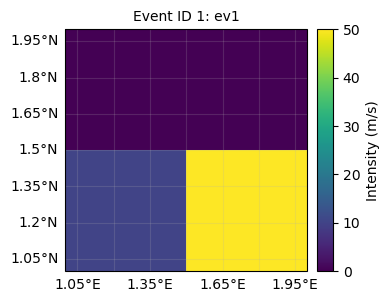

In [1]:
# import packages
import numpy as np
from scipy import sparse
import warnings

warnings.filterwarnings("ignore")

from climada.hazard.base import Hazard
from climada.hazard.centroids.centr import Centroids
from climada.util.plot import plot_from_gdf

# hazard intensity
intensity = sparse.csr_matrix([[0, 0, 10, 50], [0, 100, 100, 100]])

# hazard centroids
centroids = Centroids(lat=np.array([2, 2, 1, 1]), lon=np.array([1, 2, 1, 2]))

# define hazard
hazard = Hazard(
    haz_type="TC",
    intensity=intensity,
    fraction=np.full_like(intensity, 1),
    centroids=centroids,
    event_id=np.array([1, 2]),
    event_name=["ev1", "ev2"],
    date=np.array([1, 2]),
    orig=np.array([True, True]),
    frequency=np.array([9.0 / 100, 1.0 / 100]),
    frequency_unit="1/year",
    units="m/s",
)
hazard.intensity_thres = 0

# plot first event of Hazard object
hazard.plot_intensity(event=1, smooth=False, figsize=(4, 4));

### Compute local exceedance intensities

Given the information of the Hazard object, which hazard intensity do we expect at each centroid to reoccur at a given return period? For instance, we could ask which intensity to expect every 5, 30, and 150 years. This question is addressed by the method `Hazard.local_exceedance_intensity()` which we will explain in the following, including different parameter settings one can choose from.

To compute which intensity to expect at a centroid for a given return period, we have to infer from the Hazard object how often different intensities are exceeded. To do so, we sort the events according to their intensity at the centroid, and then, for each intensity, sum the frequencies of the events that exceed this intensity. This resulting cumulative frequency for each intensity then yields the intensitiy's return period as one over the cumulative frequency. Finally, as we see below, the return periods for new intensities have to be inter- and extrapolated from the Hazard objects data.

**Examplary calculation for centroid D**

We demonstrate this computation for centroid D. First, we sort the centroid's intensities in descending order. Centroid D has the two intensities
`intensities_descending = [100, 50]`. Then, the corresponding frequencies will be accumulated in this order, giving the cumulative frequencies
`cumulative_frequencies = [0.01, 0.1]` (note that 9/100 + 1/100 = 1/10). The return periods of the different intensities are then given by `1/cummulative_frequencies`. This means that our data for centroid D suggests that, e.g., we expect an event with an intensity that exceeds 100m/s on average every 100 years. The information for centroid D is summarized as
| intensity (m/s) | return period (years) |
| ---:     | ---:       | 
| 100      | 100        | 
| 50       | 10         | 

Now, the question is how to estimate the exceedance intensity for new return periods, e.g., 5, 30, and 150 years. 

#### Option 1 (default setting): interpolation without extrapolation

For the return periods inside the range of observed return periods (here, 30 years), one can simply interpolate between the data points. For return periods outside the range of observed return periods (here, 5 and 150 years), the cautious answer is "we don't know" and one returns NaN. This behaviour is given using `method='interpolate'` which is the default setting. 

Note that, by default, the linear interpolation between data points is done after converting the data to logarithmic scale. We do this because, when extrapolating, logarithmic scales avoid negative numbers. The scale choice can be controlled by changing the boolean parameters `log_frequency` and `log_intensity`. 

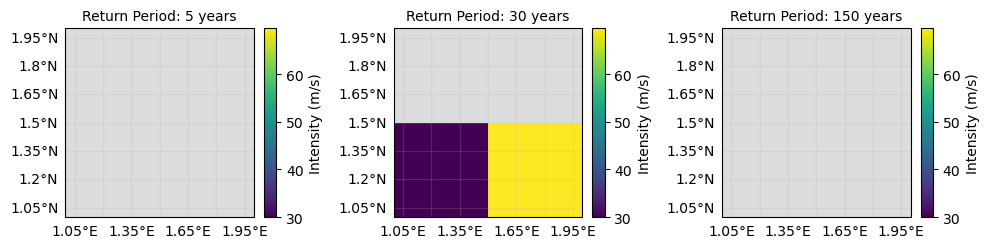

In [2]:
local_exceedance_intensity, title, column_label = hazard.local_exceedance_intensity(
    return_periods=[5, 30, 150], method="interpolate"
)
plot_from_gdf(
    local_exceedance_intensity, title, column_label, smooth=False, figsize=(10, 6)
);

#### Option 2: extrapolation

If the user wants to estimate the return periods outside the range of observed return periods (here, 5 and 150 years), they can use `method='extrapolate'`. This just extends the last interpolation piece inside the data range beyond the data borders. If there is only a single (nonzero) data point, this setting returns the given intensity (e.g., 100m/s for centroid B) for return periods above the observed return period (e.g., 100 years for centroid B), and zero intensity for return periods below. Centroids where all events have zero intensity will be assigned zero exceedance intensity for any return period.

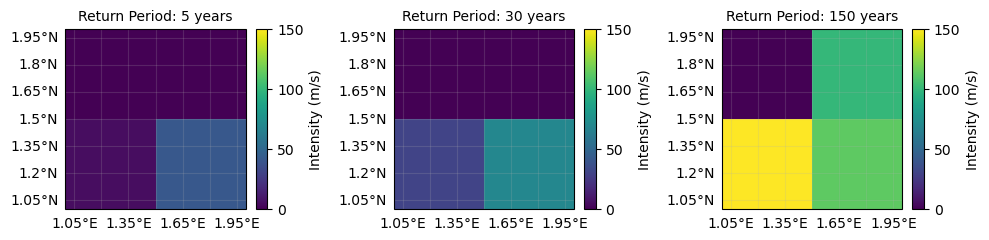

In [3]:
local_exceedance_intensity, title, column_label = hazard.local_exceedance_intensity(
    return_periods=[5, 30, 150], method="extrapolate"
)
plot_from_gdf(
    local_exceedance_intensity, title, column_label, smooth=False, figsize=(10, 6)
);

#### Option 3: extrapolation with constant values

Users who want to extrapolate in a more cautious way can use `method='extrapolate_constant'`. Here, return periods above the largest obsvered return period are assigned the largest intensity, and return periods below the smallest observed return periods are assigned 0.

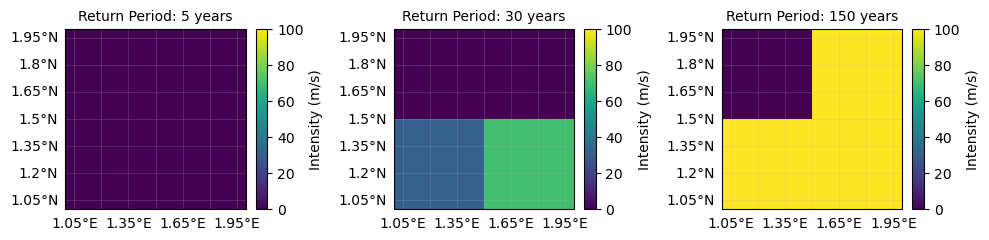

In [4]:
local_exceedance_intensity, title, column_label = hazard.local_exceedance_intensity(
    return_periods=[5, 30, 150], method="extrapolate_constant"
)
plot_from_gdf(
    local_exceedance_intensity, title, column_label, smooth=False, figsize=(10, 6)
);

#### Option 4: stepfunction

Finally, instead of interpolating between the data points, one can use `method='stepfunction'`. Here, a user-provided return period will be assigned an exceedance intensity equal to the intensity corresponding to the closest observed return period that is below the given the user-provided return period. The extrapolation behaviour is the same as for `method='extrapolate_constant'`. 

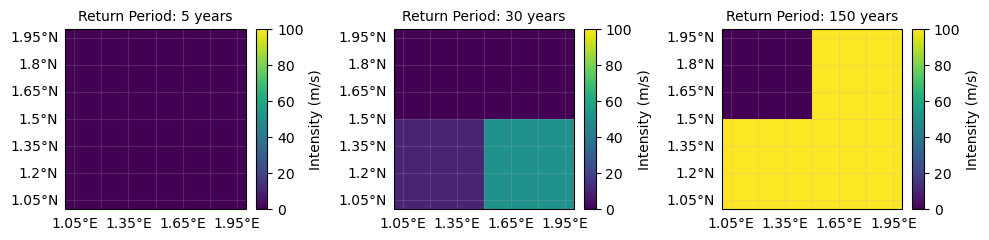

In [5]:
local_exceedance_intensity, title, column_label = hazard.local_exceedance_intensity(
    return_periods=[5, 30, 150], method="stepfunction"
)
plot_from_gdf(
    local_exceedance_intensity, title, column_label, smooth=False, figsize=(10, 6)
);

### Compute local return periods

Using `Hazard.local_return_period()`, you can locally compute the return period of events exceeding different (user-specified) threshold intensities. For instance, you could ask every how many years (on average) do we expect intensities exceeding 5m/s, 30m/s, and 150m/s.

The different settings of `Hazard.local_return_period()` are similar to the ones available in `Hazard.local_exceedance_intensity()`, see Options 1-4 above. For instance, if we use `method='extrapolate_constant'`, we obtain the local return periods shown below. Note that the main difference to the local exceedance intensities described above is that, for a threshold intensity above all observed intensities, the method assigns NaN, and for a threshold intensity below all observed intensities, the method assigns the smallest observed return period.

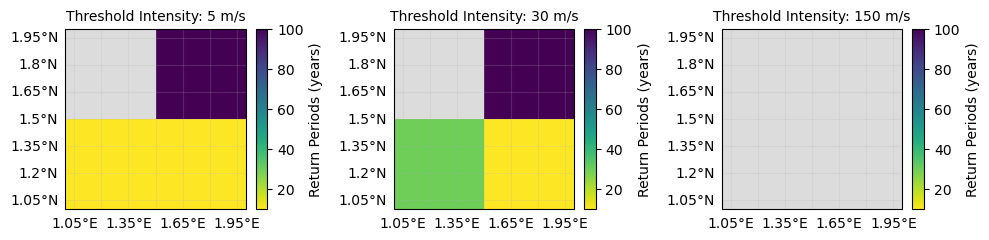

In [6]:
# method: extrapolation
local_return_period, title, column_label = hazard.local_return_period(
    threshold_intensities=[5, 30, 150], method="extrapolate_constant"
)
plot_from_gdf(local_return_period, title, column_label, smooth=False, figsize=(10, 6));

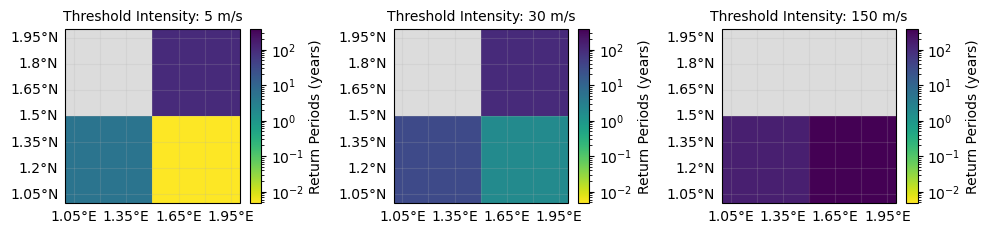

In [7]:
# method: extrapolation
local_return_period, title, column_label = hazard.local_return_period(
    threshold_intensities=[5, 30, 150], method="extrapolate"
)
plot_from_gdf(local_return_period, title, column_label, smooth=False, figsize=(10, 6));

## Method comparison for a real Hazard object

We now showcase the different settings for `Hazard.local_exceedance_intensity()` with a real example (historic tropical cyclones in Florida from 1990 to 2004). First, we read in the hazard object.


In [8]:
# load example hazard object
from climada.hazard import Hazard, Centroids
from climada.util import HAZ_DEMO_H5

haz_tc_fl = Hazard.from_hdf5(
    HAZ_DEMO_H5
)  # Historic tropical cyclones in Florida from 1990 to 2004
haz_tc_fl.check()  # Use always the check() method to see if the hazard has been loaded correctly

2024-11-06 17:24:24,267 - climada.hazard.io - INFO - Reading /Users/vgebhart/climada/demo/data/tc_fl_1990_2004.h5


Next, we plot the hazards local exceedance intensities for user-specified return periods of 10, 100 and 200 years. We use the setting `"method=extrapolate"`. Furthermore, we indicate a specific centroid (red circle) that we will analyse in more detail below. 

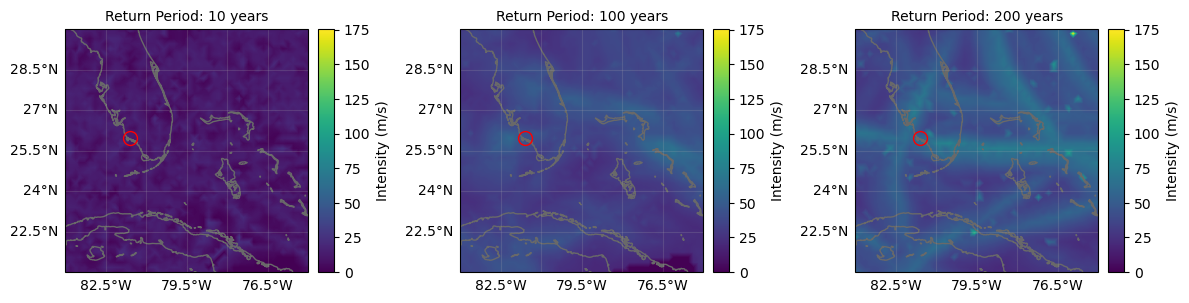

In [9]:
import cartopy.crs as ccrs

# choose centroid index for analysis below
i_centroid = 1363
coordinates_centroid = haz_tc_fl.centroids.coord[i_centroid]

local_exceedance_intensity, title, column_label = haz_tc_fl.local_exceedance_intensity(
    return_periods=[10, 100, 200], method="extrapolate"
)
axes = plot_from_gdf(local_exceedance_intensity, title, column_label, figsize=(12, 8))
for axis in axes:
    axis.plot(
        coordinates_centroid[1],
        coordinates_centroid[0],
        marker="o",
        markersize=10,
        markerfacecolor="none",
        markeredgecolor="red",
        transform=ccrs.PlateCarree(),
    )

Now, we calculate the local exceedance frequencies for return periods ranging from 5 to 250 years, using the four different options explained above.

In [10]:
test_return_periods = np.arange(5, 250, 1)
interpolated = haz_tc_fl.local_exceedance_intensity(return_periods=test_return_periods)[
    0
]
extrapolated = haz_tc_fl.local_exceedance_intensity(
    return_periods=test_return_periods, method="extrapolate"
)[0]
extrapolated_constant = haz_tc_fl.local_exceedance_intensity(
    return_periods=test_return_periods, method="extrapolate_constant"
)[0]
stepfunction = haz_tc_fl.local_exceedance_intensity(
    return_periods=test_return_periods, method="stepfunction"
)[0]

Finally, we focus on a specific centroid (red circle in above plots) and show how the different options of `Hazard.local_exceedance_intensity()` can lead to different results. The user-specified return periods from above are indicated as dotted lines. Note in particular that the return periods 5 years and 200 years that we considered above, lie outside the range of observed values for this centroid (blue scatter points). Thus, depending on the extrapolation choice, `Hazard.local_exceedance_intensity()` either returns NaN (`"method=interpolate"`, default option) or different extrapolated estimates.

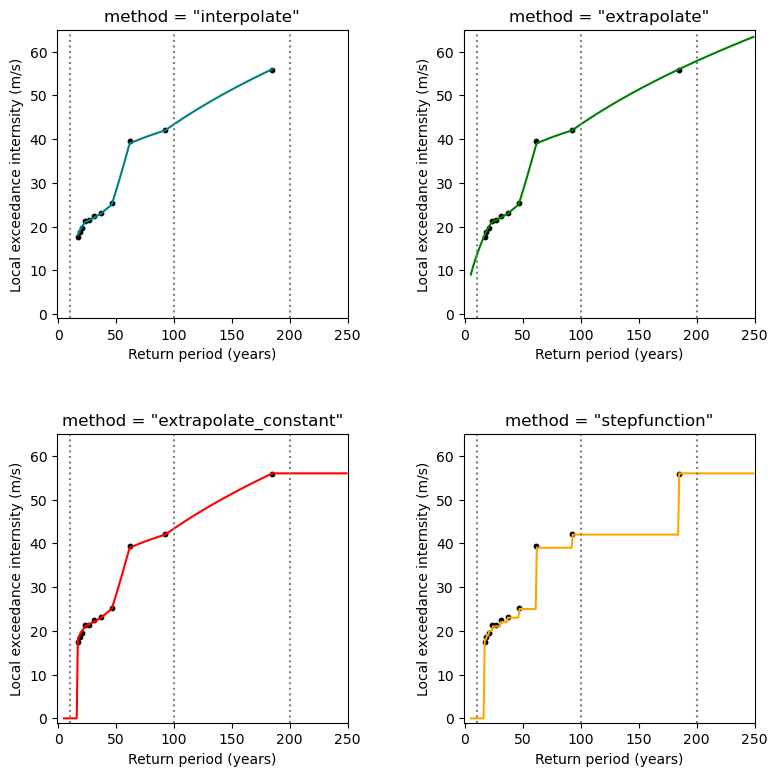

In [11]:
# plot different extrapolation methods at at centroid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(9, 9))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for axis, local_exceedance_intensity, color, title in zip(
    axes.flatten(),
    [interpolated, extrapolated, extrapolated_constant, stepfunction],
    ["teal", "g", "r", "orange"],
    ["interpolate", "extrapolate", "extrapolate_constant", "stepfunction"],
):
    axis.plot(
        test_return_periods,
        local_exceedance_intensity.values[i_centroid, 1:],
        color=color,
    )
    axis.set_ylabel("Local exceedance internsity (m/s)")
    axis.set_xlabel("Return period (years)")
    axis.scatter(
        1
        / (
            haz_tc_fl.frequency[0] * np.arange(11, 0, -1)
        ),  # sorted return periods of intensity values at centroid
        np.sort(np.unique(haz_tc_fl.intensity[:, i_centroid].toarray()))[
            1:
        ],  # sorted intensity values at centroid
        s=10,
        color="k",
    )
    axis.vlines([10, 100, 200], ymin=-1, ymax=70, linestyles=":", colors="gray")
    axis.set_title(f'method = "{title}"')
    axis.set_xlim([-1, 250])
    axis.set_ylim([-1, 65])

## Compute local exceedance impacts and local return periods of impact objects

Completely analogous to the above explained methods `Hazard.local_exceedance_intensity()` and `Hazard.local_return_period()` of a `Hazard` object, an `Impact` object has the methods `Impact.local_exceedance_impact()` and `Impact.local_return_period()` (to be added soon).



In [12]:
# prepare hazard object

import warnings

warnings.filterwarnings("ignore")

from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.engine import ImpactCalc
from climada.util.api_client import Client
from climada.util.constants import CMAP_IMPACT
from climada.util.plot import plot_from_gdf

client = Client()
haz_tc_haiti = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
haz_tc_haiti.check()

2024-11-06 17:24:51,841 - climada.hazard.io - INFO - Reading /Users/vgebhart/climada/data/hazard/tropical_cyclone/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020/v2/tropical_cyclone_10synth_tracks_150arcsec_HTI_1980_2020.hdf5


In [13]:
# prepare exposure

exposure = client.get_litpop(country="Haiti")
exposure.check()

2024-11-06 17:24:53,233 - climada.entity.exposures.base - INFO - Reading /Users/vgebhart/climada/data/exposures/litpop/LitPop_150arcsec_HTI/v3/LitPop_150arcsec_HTI.hdf5
2024-11-06 17:24:53,259 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2024-11-06 17:24:53,260 - climada.entity.exposures.base - INFO - category_id not set.
2024-11-06 17:24:53,260 - climada.entity.exposures.base - INFO - cover not set.
2024-11-06 17:24:53,260 - climada.entity.exposures.base - INFO - deductible not set.
2024-11-06 17:24:53,260 - climada.entity.exposures.base - INFO - centr_ not set.


In [14]:
# prepare impact function

impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

In [15]:
# compute impact

impact = ImpactCalc(exposure, impf_set, haz_tc_haiti).impact(save_mat=True)

2024-11-06 17:24:53,271 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2024-11-06 17:24:53,272 - climada.entity.exposures.base - INFO - Matching 1329 exposures with 1332 centroids.
2024-11-06 17:24:53,274 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-11-06 17:24:53,278 - climada.engine.impact_calc - INFO - Calculating impact for 3987 assets (>0) and 43560 events.


In [16]:
# compute local exceedance impacts

return_periods = [10, 50, 100, 200]
loacl_exceedance_impacts, title, column_label = impact.local_exceedance_impact(
    return_periods=return_periods
)

2024-11-06 17:24:53,292 - climada.engine.impact - INFO - Computing exceedance impact map for return periods: [10, 50, 100, 200]


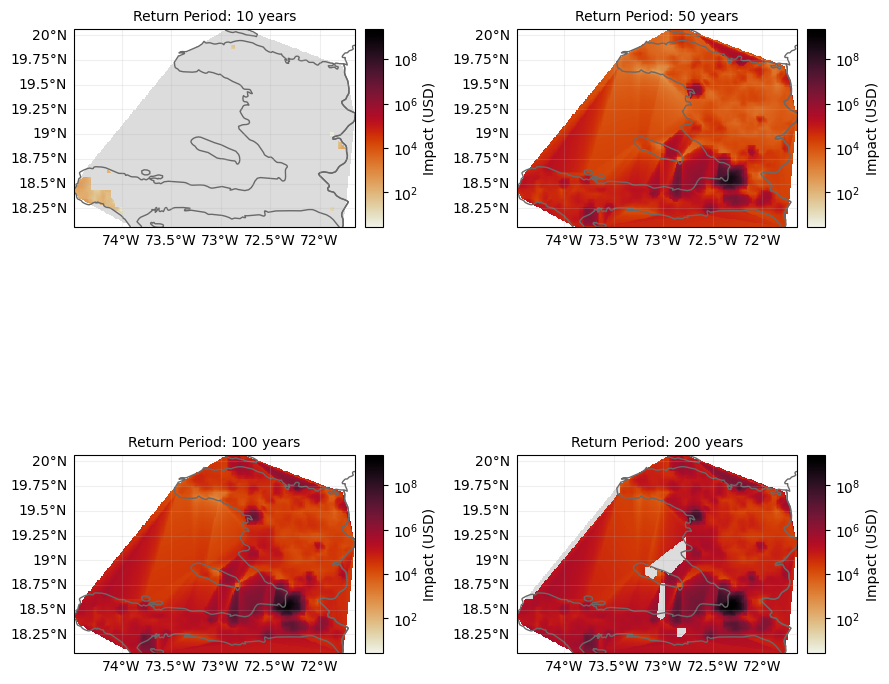

In [17]:
# plot local exceedance impacts
plot_from_gdf(
    loacl_exceedance_impacts, title, column_label, smooth=False, cmap=CMAP_IMPACT
);

In [18]:
# compute local return periods of impact
threshold_impact = [1000, 10000, 100000, 1000000]
local_return_periods, title, column_label = impact.local_return_period(
    threshold_impact=threshold_impact
)

2024-11-06 17:25:22,402 - climada.engine.impact - INFO - Computing return period map for impacts: [1000, 10000, 100000, 1000000]


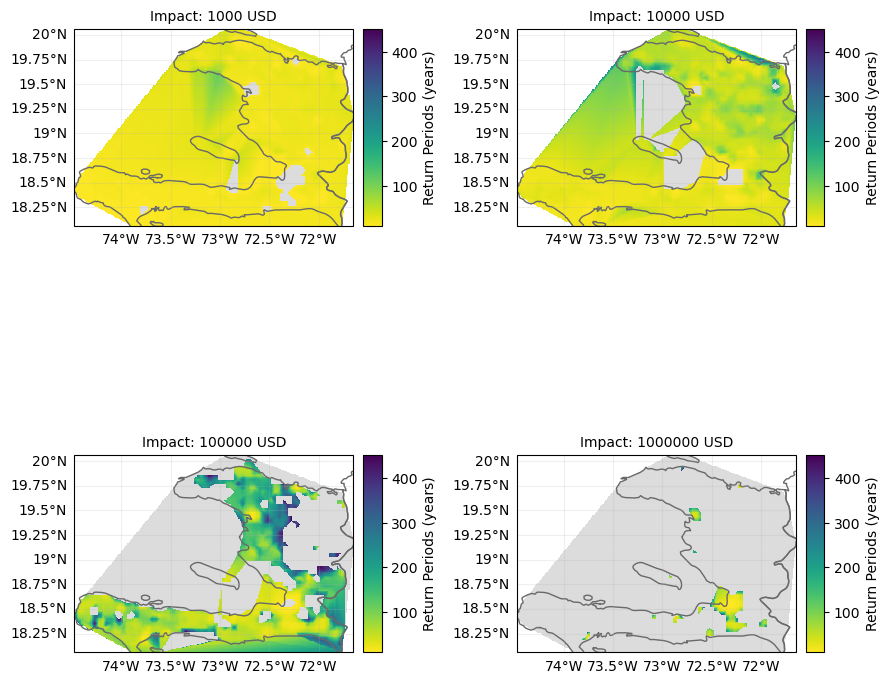

In [19]:
# plot local return periods of impacts
plot_from_gdf(local_return_periods, title, column_label, smooth=False);